In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms,models
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from joblib import dump,load
import joblib
import matplotlib.pyplot as plt

import itertools
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Notes: Could use Augmentation
Could add layer to transform from greyscale

### Evaluation functions


In [ ]:
from sklearn.metrics import roc_auc_score

def OD_Test(Dataset_s,Dataset_v,Dataset_t):
  '''
    Perform an Out of ditribution test with the input datasets.

    Input: Dataset_s: tuple of 3 dataloaders, train val and test
           Dataset_v: validation dataloader
           Dataset_t: test dataloader
  '''
  in_train = Dataset_s[0]
  in_val = Dataset_s[1]
  in_test = Dataset_s[2]

  kde = KDE(in_train)
  cutoff = tune(in_val,Dataset_v,kde)
  print(cutoff)
  print(evaluate(in_test,Dataset_t,kde,cutoff))



def KDE(X_Train):
  #KDE
  #use grid search cross-validation to optimize the bandwidth
  params = {'bandwidth':  np.logspace(-6,1, 40)}
  grid = GridSearchCV(KernelDensity(), params)
  grid.fit(X_Train)
  print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

  #use the best estimator to compute the kernel density estimate
  kde = grid.best_estimator_

  return kde

  #print('bandwidth: ', bandwidth)
  #print('leaf_size: ', leaf_size)

  #kde = KernelDensity(bandwidth=bandwidth,leaf_size=leaf_size)
  #kde.fit(X_Train)
  #return kde


def tune(score_in,score_out):
  '''
  Given an in dictribution and an out dictribution return the optimum cutoff
  '''
  num_evals=100
  total_len = (len(score_in)+len(score_out))
  cutoff = [np.percentile(score_in,float(i)) for i in range(num_evals+1)]
  acc = [(len(score_in[score_in>t])+len(score_out[score_out<t]))/total_len for t in cutoff]
  print('cutoff percentile: ',np.argmax(acc))
  return cutoff[np.argmax(acc)]


def evaluate(score_in, score_out,cutoff):
  '''
  Given an in distribution dataset (numpy), an out of distribution dataset (numpy) and a trained kde classfier and a cutoff
  Return the accuracy
  '''
  scores = np.concatenate((score_in,score_out))
  lables = np.concatenate( (np.ones(score_in.shape[0]),np.zeros(score_out.shape[0])))
  aucroc= roc_auc_score(lables,scores)
  total_len = (len(score_in)+len(score_out))
  acc = (len(score_in[score_in>cutoff])+len(score_out[score_out<cutoff]))/total_len
  return acc,aucroc

###Train model

In [ ]:
def train_model(ds,model,ds_name,net_name,feature_extract = True,num_epochs=10,lr=0.0005):
  # options is a dictionary containing Net,Net_name

  transform = transforms.Compose([transforms.ToTensor()])
  train_loader = torch.utils.data.DataLoader(ds, batch_size=32, shuffle=True)

  #Tain Neural Network

  # Check for GPU
  if torch.cuda.is_available():
      device = torch.device("cuda")
  else:
      device = torch.device("cpu")

  print(device)

  if torch.cuda.is_available():
      torch.cuda.manual_seed_all(1999)

  model=model.to(device)
  log_epoch = max(num_epochs//50,1)
  loss_function = torch.nn.CrossEntropyLoss().to(device)

  params_to_update = model.parameters()

  print("Params to learn:")
  if feature_extract:
      params_to_update = []
      for name,param in model.named_parameters():
          if param.requires_grad == True:
              params_to_update.append(param)
              print("\t",name)
  else:
      for name,param in model.named_parameters():
          if param.requires_grad == True:
              print("\t",name)

  optimizer = optim.SGD(params_to_update, lr=lr)

  model.train()
  print('training on ',ds_name, ' with ', net_name)
  for epoch in range(num_epochs):
        l=0
        correct=0
        for i, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs, final = model(data)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            if epoch% log_epoch ==0:
              l+=loss.item()
              correct += len(labels[torch.argmax(outputs,axis=1)==labels])

        if epoch% log_epoch ==0:
          print(f'Epoch: {epoch}, loss: {l}, accuracy : {correct/len(ds)}')     

  return model

def evaluate_model(ds,model):
  model.eval()

  transform = transforms.Compose([transforms.ToTensor()])
  eval_loader = torch.utils.data.DataLoader(ds, batch_size=64, shuffle=True)

# Check for GPU
  if torch.cuda.is_available():
      device = torch.device("cuda")
  else:
      device = torch.device("cpu")

  print(device)
  model=model.to(device)

  correct = 0
  for i, (data, labels) in enumerate(eval_loader):
              data = data.to(device)
              labels = labels.to(device)
              outputs, final = model(data)
              correct += len(labels[torch.argmax(outputs,axis=1)==labels])
  return correct/len(ds)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

def get_classifier(in_vals,out_vals):
  x = np.concatenate((in_vals,out_vals))
  y = np.concatenate((np.ones(len(in_vals)),np.zeros(len(in_vals))))
  scaler = preprocessing.StandardScaler().fit(x)
  x=scaler.transform(x)  
  clf = LogisticRegression( max_iter=10000).fit(x,y)
  return clf,scaler



### Def Datasets


In [ ]:
val_size = 5000

# Process datasets
dataset_names = ['mnist','kmnist','fmnist','cifar10','stl10']

input_size = 32
data_transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

def get_dataset(name):
  if name == 'mnist':
    train = datasets.MNIST('./MNIST/', train=True, transform=data_transform, download=True)
    train,val = torch.utils.data.random_split(train, [len(train)-val_size, val_size])
    test= datasets.MNIST('./MNIST/', train=False, transform=data_transform, download=True)
  elif name == 'fmnist':
    train = datasets.FashionMNIST('./FMNIST/', train=True, transform=data_transform, download=True)
    train,val = torch.utils.data.random_split(train, [len(train)-val_size, val_size])
    test= datasets.FashionMNIST('./FMNIST/', train=False, transform=data_transform, download=True)
  elif name == 'kmnist':
    train = datasets.KMNIST('./KMNIST/', train=True, transform=data_transform, download=True)
    train,val = torch.utils.data.random_split(train, [len(train)-val_size, val_size])
    test= datasets.KMNIST('./KMNIST/', train=False, transform=data_transform, download=True)
  elif name == 'cifar10':
    train = datasets.CIFAR10('./CIFAR10/', train=True, transform=data_transform, download=True)
    train,val = torch.utils.data.random_split(train, [len(train)-val_size, val_size])
    test= datasets.CIFAR10('./CIFAR10/', train=False, transform=data_transform, download=True)

  elif name == 'stl10':
    train = datasets.STL10('./STL10/', transform=data_transform, download=True,split='train')
    val = train
    test= datasets.STL10('./STL10/', transform=data_transform, download=True,split='test')
  else:
    print('invalid dataset')
  return train,val,test

for name in dataset_names:
  train,val,test = get_dataset(name)
  print(len(test.classes))

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw


Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw
Processing...
Done!
10


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./KMNIST/KMNIST/raw/train-images-idx3-ubyte.gz to ./KMNIST/KMNIST/raw


Extracting ./KMNIST/KMNIST/raw/train-labels-idx1-ubyte.gz to ./KMNIST/KMNIST/raw


Extracting ./KMNIST/KMNIST/raw/t10k-images-idx3-ubyte.gz to ./KMNIST/KMNIST/raw


Extracting ./KMNIST/KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./KMNIST/KMNIST/raw
Processing...
Done!
10





Extracting ./FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FMNIST/FashionMNIST/raw


Extracting ./FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FMNIST/FashionMNIST/raw


Extracting ./FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FMNIST/FashionMNIST/raw


Extracting ./FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FMNIST/FashionMNIST/raw
Processing...
Done!
10





Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10/
Files already downloaded and verified
10


Extracting ./STL10/stl10_binary.tar.gz to ./STL10/
Files already downloaded and verified
10


### Define model

In [ ]:
#https://github.com/chengyangfu/pytorch-vgg-cifar10/blob/master/main.py

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

model_names = ['vgg11', 'vgg13', 'vgg16', 'vgg19']


import math

import torch.nn as nn
import torch.nn.init as init

__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


class VGG(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, features,rep_dim):
        super(VGG, self).__init__()
        self.features = features
        self.compress = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, rep_dim)   
        )
        self.classifier = nn.Sequential(
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(rep_dim, rep_dim),
            nn.ReLU(True),
            nn.Linear(rep_dim, 10),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        rep = self.compress(x)
        out = self.classifier(rep)
        return out,rep


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
          512, 512, 512, 512, 'M'],
}


def vgg11(rep_dim):
    """VGG 11-layer model (configuration "A")"""
    return VGG(make_layers(cfg['A']),rep_dim)


def vgg11_bn(rep_dim):
    """VGG 11-layer model (configuration "A") with batch normalization"""
    return VGG(make_layers(cfg['A'], batch_norm=True),rep_dim)


def vgg13(rep_dim):
    """VGG 13-layer model (configuration "B")"""
    return VGG(make_layers(cfg['B']),rep_dim)


def vgg13_bn(rep_dim):
    """VGG 13-layer model (configuration "B") with batch normalization"""
    return VGG(make_layers(cfg['B'], batch_norm=True),rep_dim)


def vgg16(rep_dim):
    """VGG 16-layer model (configuration "D")"""
    return VGG(make_layers(cfg['D']),rep_dim)


def vgg16_bn(rep_dim):
    """VGG 16-layer model (configuration "D") with batch normalization"""
    return VGG(make_layers(cfg['D'], batch_norm=True),rep_dim)


def vgg19(rep_dim):
    """VGG 19-layer model (configuration "E")"""
    return VGG(make_layers(cfg['E']),rep_dim)


def vgg19_bn(rep_dim):
    """VGG 19-layer model (configuration 'E') with batch normalization"""
    return VGG(make_layers(cfg['E'], batch_norm=True),rep_dim)



def initialize_model(model_name, rep_dim):
    if model_name == "vgg11":
        model = vgg11(rep_dim)
    elif model_name == "vgg13":
        model = vgg13(rep_dim)
    elif model_name == "vgg16":
        model = vgg16(rep_dim)
    elif model_name == "vgg19":
        model = vgg19(rep_dim)
    else:
        print("Invalid model name, exiting...")
        exit()
    return model


### Compress

In [ ]:
def compress(dataset,model,rep_dim,max_len=50000):
  model.eval()
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")
  model = model.to(device)
  out = np.zeros((len(dataset),rep_dim))
  i_0 = 0
  loader = DataLoader(dataset, batch_size=1000,shuffle = True)
  with torch.no_grad():
    for i,(x,v) in enumerate(loader):
        comp = model(x.to(device))[1].cpu().numpy()
        i_1=comp.shape[0]+i_0
        out[i_0:i_1,:]=comp
        i_0=i_1
        if i_1>max_len:
          break
  return out[:max_len]

def compress_logit(dataset,model):
  model.eval()

  device = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")

  model = model.to(device)

  out = np.zeros((len(dataset),10))
  i_0 = 0
  loader = DataLoader(dataset, batch_size=1000,shuffle = True)
  for i,(x,v) in enumerate(loader):
    with torch.no_grad():
      x=model(x.to(device))[0].cpu().numpy()
      i_1=x.shape[0]+i_0
      out[i_0:i_1,:]=x
      i_0=i_1
  return out

def get_i(dataset,model,rep_dim,i):
  model.eval()
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")
  model = model.to(device)

  loader = DataLoader(dataset, batch_size=1000,shuffle = True)
  first = True
  for i,(x,v) in enumerate(loader):
    with torch.no_grad():
      x=model(x.to(device))[1].cpu().numpy()
      if first:
        out=x[v==1]
        first = False
      else:
        out.append(x[v==i])
  return out

### Run

initializing mnist
initializing fmnist
initializing kmnist
initializing cifar10
Files already downloaded and verified
Files already downloaded and verified
initializing stl10
Files already downloaded and verified
Files already downloaded and verified
loaded model vgg11-mnist-100
loaded model vgg11-fmnist-100
loaded model vgg11-kmnist-100
loaded model vgg11-cifar10-100
loaded model vgg11-stl10-100
loaded compressed vgg11-mnist-100-train
loaded compressed vgg11-mnist-100-mnist-val
loaded compressed vgg11-mnist-100-fmnist-val
loaded compressed vgg11-mnist-100-kmnist-val
loaded compressed vgg11-mnist-100-cifar10-val
loaded compressed vgg11-mnist-100-stl10-val
loaded compressed vgg11-mnist-100-mnist-test
loaded compressed vgg11-mnist-100-fmnist-test
loaded compressed vgg11-mnist-100-kmnist-test
loaded compressed vgg11-mnist-100-cifar10-test
loaded compressed vgg11-mnist-100-stl10-test
loaded compressed vgg11-fmnist-100-train
loaded compressed vgg11-fmnist-100-mnist-val
loaded compressed vgg

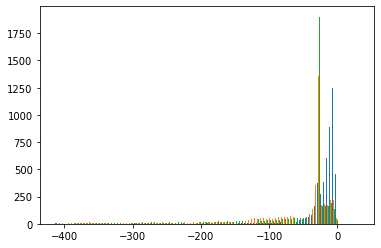

Natural drift:  -67.62299149426052 -39.05420535125947
cutoff percentile:  22
cutoff:  -25.768888710106385
acc:  0.7844
acc in: 0.7732
acc out 0.7956
vgg11-mnist-100
(0.8418, 0.8406308)


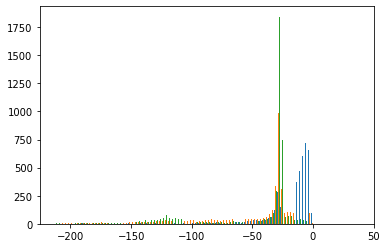

Natural drift:  -67.62299149426052 -39.05420535125947
cutoff percentile:  22
cutoff:  -25.768888710106385
acc:  0.7844
acc in: 0.7732
acc out 0.7956
vgg11-mnist-100
(0.8455, 0.8437294799999999)


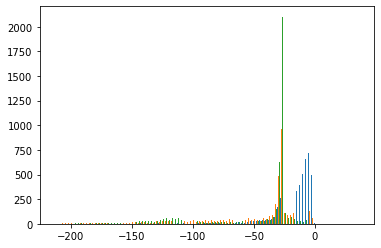

Natural drift:  -67.62299149426052 -39.05420535125947
cutoff percentile:  22
cutoff:  -25.768888710106385
acc:  0.8007
acc in: 0.7732
acc out 0.8282
vgg11-mnist-100
(0.7844, 0.81806852)


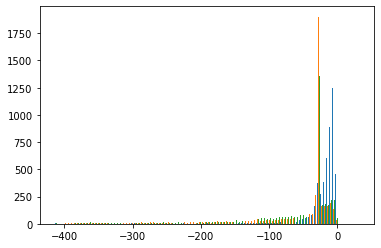

Natural drift:  -67.62299149426052 -39.05420535125947
cutoff percentile:  22
cutoff:  -25.768888710106385
acc:  0.8007
acc in: 0.7732
acc out 0.8282
vgg11-mnist-100
(0.8418, 0.8406308)


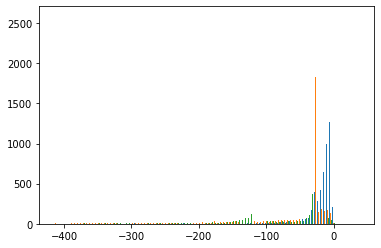

Natural drift:  -67.62299149426052 -39.05420535125947
cutoff percentile:  22
cutoff:  -25.768888710106385
acc:  0.8007
acc in: 0.7732
acc out 0.8282
vgg11-mnist-100
(0.8455, 0.8437294799999999)


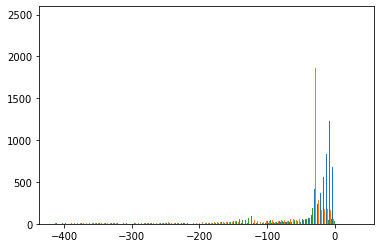

Natural drift:  -67.62299149426052 -39.05420535125947
cutoff percentile:  22
cutoff:  -25.768888710106385
acc:  0.8418
acc in: 0.7732
acc out 0.9104
vgg11-mnist-100
(0.7844, 0.81806852)


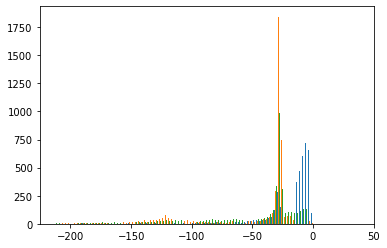

Natural drift:  -67.62299149426052 -39.05420535125947
cutoff percentile:  22
cutoff:  -25.768888710106385
acc:  0.8418
acc in: 0.7732
acc out 0.9104
vgg11-mnist-100
(0.8007, 0.8232170400000001)


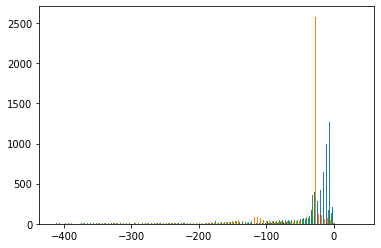

Natural drift:  -67.62299149426052 -39.05420535125947
cutoff percentile:  22
cutoff:  -25.768888710106385
acc:  0.8418
acc in: 0.7732
acc out 0.9104
vgg11-mnist-100
(0.8455, 0.8437294799999999)


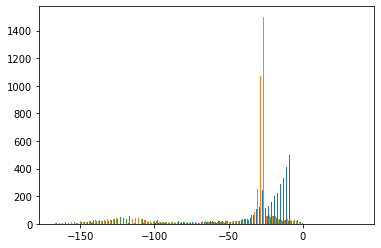

Natural drift:  -67.62299149426052 -39.05420535125947
cutoff percentile:  22
cutoff:  -25.768888710106385
acc:  0.8455
acc in: 0.7732
acc out 0.9178
vgg11-mnist-100
(0.7844, 0.81806852)


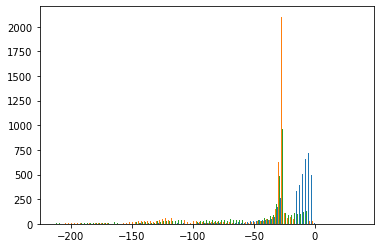

Natural drift:  -67.62299149426052 -39.05420535125947
cutoff percentile:  22
cutoff:  -25.768888710106385
acc:  0.8455
acc in: 0.7732
acc out 0.9178
vgg11-mnist-100
(0.8007, 0.8232170400000001)


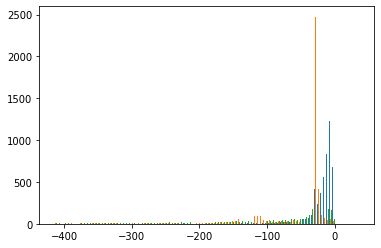

Natural drift:  -67.62299149426052 -39.05420535125947
cutoff percentile:  22
cutoff:  -25.768888710106385
acc:  0.8455
acc in: 0.7732
acc out 0.9178
vgg11-mnist-100
(0.8418, 0.8406308)


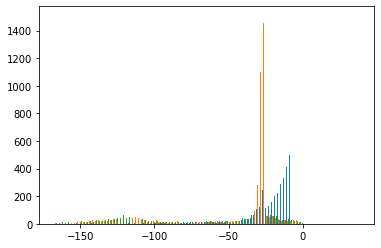

Natural drift:  -67.62299149426052 -39.05420535125947
logistic:  {}
KDE trained on mnist. Cutoff chosen to spilt mnist and the first dataset optimally. Then evaluated on the second dataset.
test:  {'vgg11-mnist-100-fmnist-kmnist': [0.8007, 0.8232170400000001, 0.9244, 0.989], 'vgg11-mnist-100-fmnist-cifar10': [0.8418, 0.8406308, 0.9851, 0.989], 'vgg11-mnist-100-fmnist-stl10': [0.8455, 0.8437294799999999, 0.9844, 0.989], 'vgg11-mnist-100-kmnist-fmnist': [0.7844, 0.81806852, 0.9668, 0.989], 'vgg11-mnist-100-kmnist-cifar10': [0.8418, 0.8406308, 0.967, 0.989], 'vgg11-mnist-100-kmnist-stl10': [0.8455, 0.8437294799999999, 0.9675, 0.989], 'vgg11-mnist-100-cifar10-fmnist': [0.7844, 0.81806852, 0.9722, 0.989], 'vgg11-mnist-100-cifar10-kmnist': [0.8007, 0.8232170400000001, 0.9264, 0.989], 'vgg11-mnist-100-cifar10-stl10': [0.8455, 0.8437294799999999, 0.9873, 0.989], 'vgg11-mnist-100-stl10-fmnist': [0.7844, 0.81806852, 0.9691, 0.989], 'vgg11-mnist-100-stl10-kmnist': [0.8007, 0.8232170400000001, 0.9

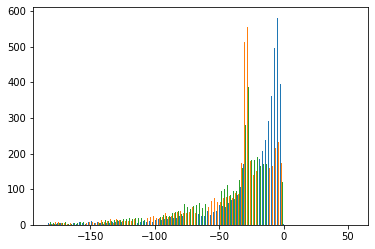

Natural drift:  -82.97345445251493 -42.58346486446576
cutoff percentile:  38
cutoff:  -24.434099606759236
acc:  0.6394
acc in: 0.6178
acc out 0.661
vgg11-fmnist-100
(0.6036, 0.60804908)


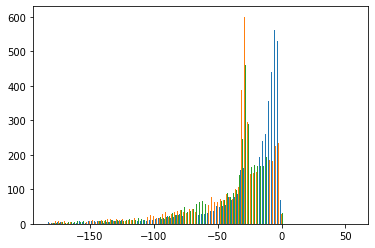

Natural drift:  -82.97345445251493 -42.58346486446576
cutoff percentile:  38
cutoff:  -24.434099606759236
acc:  0.6394
acc in: 0.6178
acc out 0.661
vgg11-fmnist-100
(0.5683, 0.55679056)


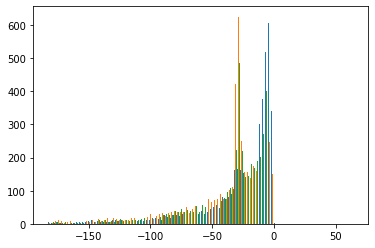

Natural drift:  -82.97345445251493 -42.58346486446576
cutoff percentile:  45
cutoff:  -18.716602535326825
acc:  0.6316
acc in: 0.5404
acc out 0.7228
vgg11-fmnist-100
(0.6346, 0.6398544800000001)


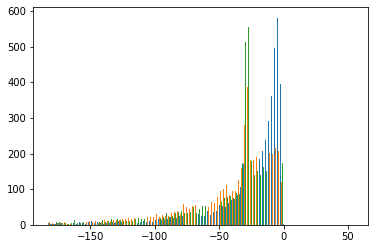

Natural drift:  -82.97345445251493 -42.58346486446576
cutoff percentile:  45
cutoff:  -18.716602535326825
acc:  0.6316
acc in: 0.5404
acc out 0.7228
vgg11-fmnist-100
(0.6047, 0.60804908)


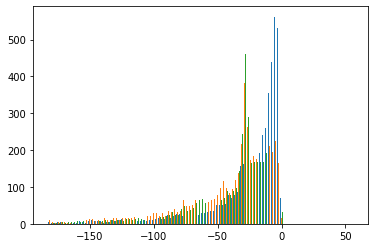

Natural drift:  -82.97345445251493 -42.58346486446576
cutoff percentile:  45
cutoff:  -18.716602535326825
acc:  0.6316
acc in: 0.5404
acc out 0.7228
vgg11-fmnist-100
(0.5636, 0.55679056)


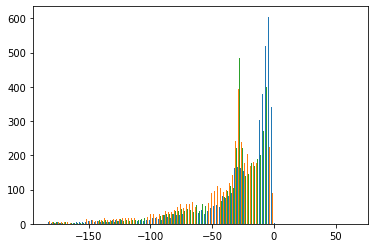

Natural drift:  -82.97345445251493 -42.58346486446576
cutoff percentile:  46
cutoff:  -17.96753176252986
acc:  0.6056
acc in: 0.529
acc out 0.6822
vgg11-fmnist-100
(0.6339, 0.6398544800000001)


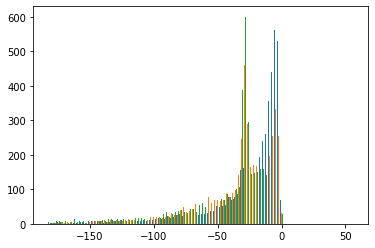

Natural drift:  -82.97345445251493 -42.58346486446576
cutoff percentile:  46
cutoff:  -17.96753176252986
acc:  0.6056
acc in: 0.529
acc out 0.6822
vgg11-fmnist-100
(0.6305, 0.64985364)


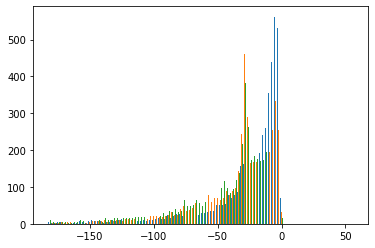

Natural drift:  -82.97345445251493 -42.58346486446576
cutoff percentile:  46
cutoff:  -17.96753176252986
acc:  0.6056
acc in: 0.529
acc out 0.6822
vgg11-fmnist-100
(0.5643, 0.55679056)


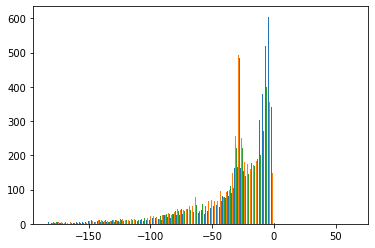

Natural drift:  -82.97345445251493 -42.58346486446576
cutoff percentile:  37
cutoff:  -25.218146223767484
acc:  0.5682
acc in: 0.6264
acc out 0.51
vgg11-fmnist-100
(0.6379, 0.6398544800000001)


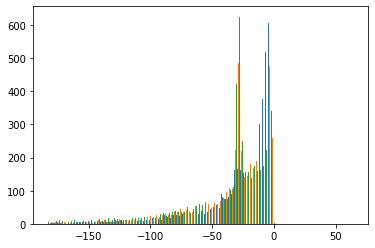

Natural drift:  -82.97345445251493 -42.58346486446576
cutoff percentile:  37
cutoff:  -25.218146223767484
acc:  0.5682
acc in: 0.6264
acc out 0.51
vgg11-fmnist-100
(0.6252, 0.64985364)


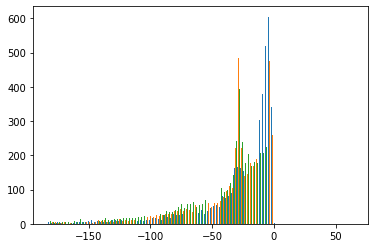

Natural drift:  -82.97345445251493 -42.58346486446576
cutoff percentile:  37
cutoff:  -25.218146223767484
acc:  0.5682
acc in: 0.6264
acc out 0.51
vgg11-fmnist-100
(0.6036, 0.60804908)


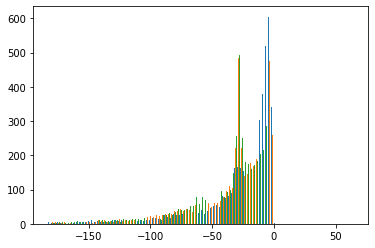

Natural drift:  -82.97345445251493 -42.58346486446576
logistic:  {}
KDE trained on fmnist. Cutoff chosen to spilt mnist and the first dataset optimally. Then evaluated on the second dataset.
test:  {'vgg11-mnist-100-fmnist-kmnist': [0.8007, 0.8232170400000001, 0.9244, 0.989], 'vgg11-mnist-100-fmnist-cifar10': [0.8418, 0.8406308, 0.9851, 0.989], 'vgg11-mnist-100-fmnist-stl10': [0.8455, 0.8437294799999999, 0.9844, 0.989], 'vgg11-mnist-100-kmnist-fmnist': [0.7844, 0.81806852, 0.9668, 0.989], 'vgg11-mnist-100-kmnist-cifar10': [0.8418, 0.8406308, 0.967, 0.989], 'vgg11-mnist-100-kmnist-stl10': [0.8455, 0.8437294799999999, 0.9675, 0.989], 'vgg11-mnist-100-cifar10-fmnist': [0.7844, 0.81806852, 0.9722, 0.989], 'vgg11-mnist-100-cifar10-kmnist': [0.8007, 0.8232170400000001, 0.9264, 0.989], 'vgg11-mnist-100-cifar10-stl10': [0.8455, 0.8437294799999999, 0.9873, 0.989], 'vgg11-mnist-100-stl10-fmnist': [0.7844, 0.81806852, 0.9691, 0.989], 'vgg11-mnist-100-stl10-kmnist': [0.8007, 0.8232170400000001, 0.

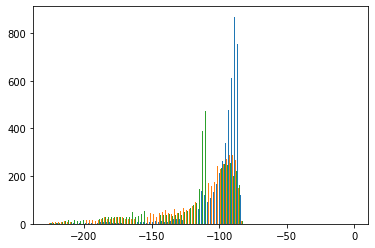

Natural drift:  -100.85455647928202 -115.77671067408761
cutoff percentile:  26
cutoff:  -94.97061559504716
acc:  0.686
acc in: 0.611
acc out 0.761
vgg11-kmnist-100
(0.7353, 0.7544690800000001)


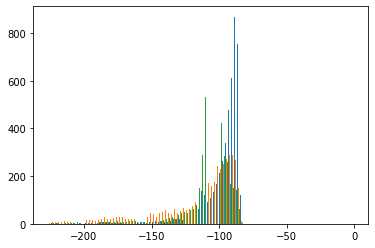

Natural drift:  -100.85455647928202 -115.77671067408761
cutoff percentile:  26
cutoff:  -94.97061559504716
acc:  0.686
acc in: 0.611
acc out 0.761
vgg11-kmnist-100
(0.7332, 0.74754784)


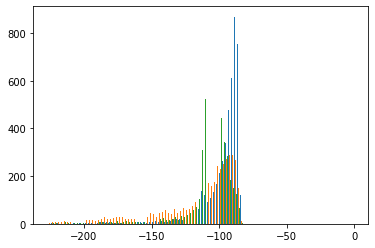

Natural drift:  -100.85455647928202 -115.77671067408761
cutoff percentile:  24
cutoff:  -95.87355182681986
acc:  0.7082
acc in: 0.639
acc out 0.7774
vgg11-kmnist-100
(0.6889, 0.7442538000000001)


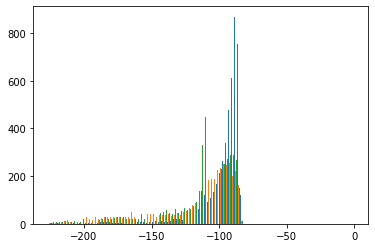

Natural drift:  -100.85455647928202 -115.77671067408761
cutoff percentile:  24
cutoff:  -95.87355182681986
acc:  0.7082
acc in: 0.639
acc out 0.7774
vgg11-kmnist-100
(0.7394, 0.7544690800000001)


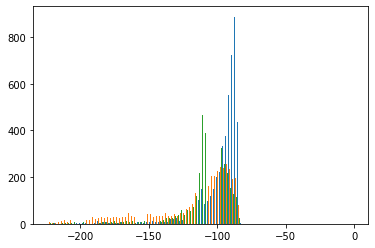

Natural drift:  -100.85455647928202 -115.77671067408761
cutoff percentile:  24
cutoff:  -95.87355182681986
acc:  0.7082
acc in: 0.639
acc out 0.7774
vgg11-kmnist-100
(0.7352, 0.74754784)


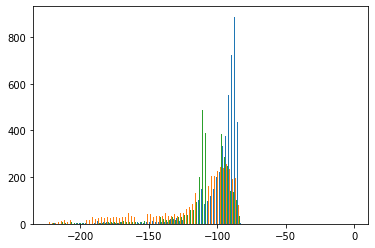

Natural drift:  -100.85455647928202 -115.77671067408761
cutoff percentile:  25
cutoff:  -95.47224825714697
acc:  0.7391
acc in: 0.6282
acc out 0.85
vgg11-kmnist-100
(0.6886, 0.7442538000000001)


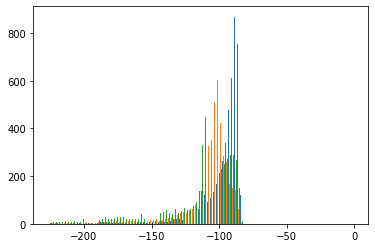

Natural drift:  -100.85455647928202 -115.77671067408761
cutoff percentile:  25
cutoff:  -95.47224825714697
acc:  0.7391
acc in: 0.6282
acc out 0.85
vgg11-kmnist-100
(0.7071, 0.76053356)


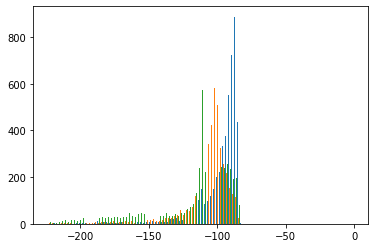

Natural drift:  -100.85455647928202 -115.77671067408761
cutoff percentile:  25
cutoff:  -95.47224825714697
acc:  0.7391
acc in: 0.6282
acc out 0.85
vgg11-kmnist-100
(0.7354, 0.74754784)


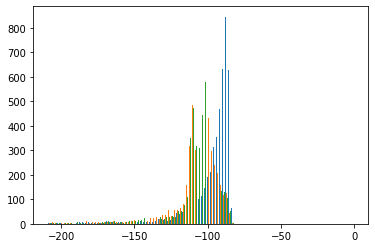

Natural drift:  -100.85455647928202 -115.77671067408761
cutoff percentile:  26
cutoff:  -94.97061559504716
acc:  0.7332
acc in: 0.611
acc out 0.8554
vgg11-kmnist-100
(0.686, 0.7442538000000001)


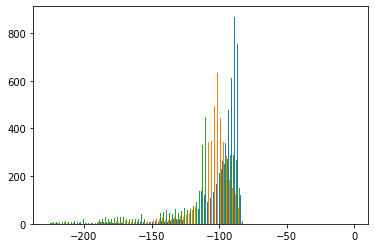

Natural drift:  -100.85455647928202 -115.77671067408761
cutoff percentile:  26
cutoff:  -94.97061559504716
acc:  0.7332
acc in: 0.611
acc out 0.8554
vgg11-kmnist-100
(0.7036, 0.76053356)


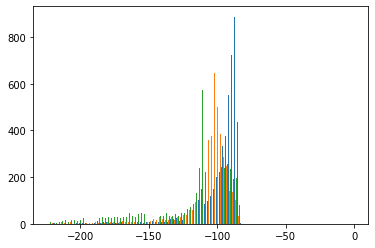

Natural drift:  -100.85455647928202 -115.77671067408761
cutoff percentile:  26
cutoff:  -94.97061559504716
acc:  0.7332
acc in: 0.611
acc out 0.8554
vgg11-kmnist-100
(0.7353, 0.7544690800000001)


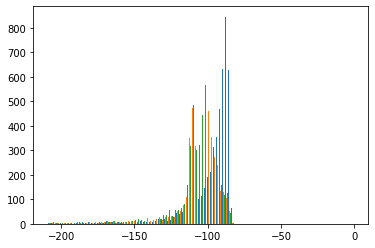

Natural drift:  -100.85455647928202 -115.77671067408761
logistic:  {}
KDE trained on kmnist. Cutoff chosen to spilt mnist and the first dataset optimally. Then evaluated on the second dataset.
test:  {'vgg11-mnist-100-fmnist-kmnist': [0.8007, 0.8232170400000001, 0.9244, 0.989], 'vgg11-mnist-100-fmnist-cifar10': [0.8418, 0.8406308, 0.9851, 0.989], 'vgg11-mnist-100-fmnist-stl10': [0.8455, 0.8437294799999999, 0.9844, 0.989], 'vgg11-mnist-100-kmnist-fmnist': [0.7844, 0.81806852, 0.9668, 0.989], 'vgg11-mnist-100-kmnist-cifar10': [0.8418, 0.8406308, 0.967, 0.989], 'vgg11-mnist-100-kmnist-stl10': [0.8455, 0.8437294799999999, 0.9675, 0.989], 'vgg11-mnist-100-cifar10-fmnist': [0.7844, 0.81806852, 0.9722, 0.989], 'vgg11-mnist-100-cifar10-kmnist': [0.8007, 0.8232170400000001, 0.9264, 0.989], 'vgg11-mnist-100-cifar10-stl10': [0.8455, 0.8437294799999999, 0.9873, 0.989], 'vgg11-mnist-100-stl10-fmnist': [0.7844, 0.81806852, 0.9691, 0.989], 'vgg11-mnist-100-stl10-kmnist': [0.8007, 0.8232170400000001, 

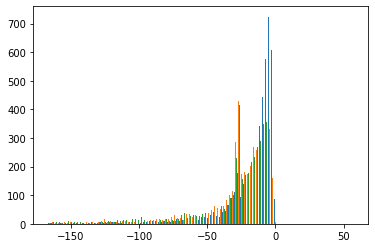

Natural drift:  -43.15279859148215 -51.63644685058283
cutoff percentile:  38
cutoff:  -14.286331797707657
acc:  0.6341
acc in: 0.604
acc out 0.6642
vgg11-cifar10-100
(0.523, 0.53441032)


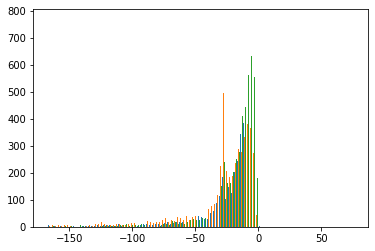

Natural drift:  -43.15279859148215 -51.63644685058283
cutoff percentile:  38
cutoff:  -14.286331797707657
acc:  0.6341
acc in: 0.604
acc out 0.6642
vgg11-cifar10-100
(0.4989, 0.49624824)


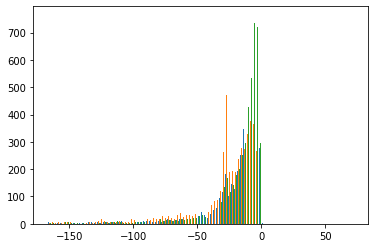

Natural drift:  -43.15279859148215 -51.63644685058283
cutoff percentile:  38
cutoff:  -14.286331797707657
acc:  0.6129
acc in: 0.604
acc out 0.6218
vgg11-cifar10-100
(0.6341, 0.66775964)


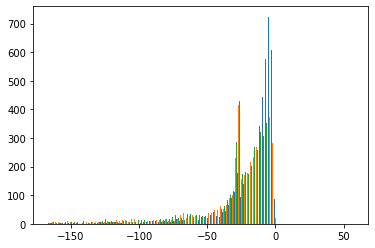

Natural drift:  -43.15279859148215 -51.63644685058283
cutoff percentile:  38
cutoff:  -14.286331797707657
acc:  0.6129
acc in: 0.604
acc out 0.6218
vgg11-cifar10-100
(0.523, 0.53441032)


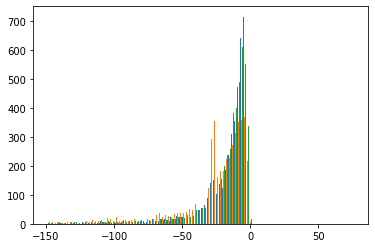

Natural drift:  -43.15279859148215 -51.63644685058283
cutoff percentile:  38
cutoff:  -14.286331797707657
acc:  0.6129
acc in: 0.604
acc out 0.6218
vgg11-cifar10-100
(0.4989, 0.49624824)


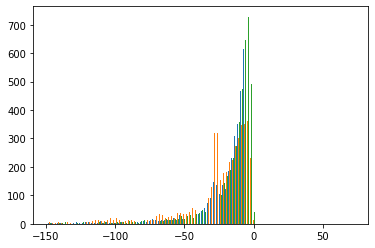

Natural drift:  -43.15279859148215 -51.63644685058283
cutoff percentile:  65
cutoff:  -6.552998679432699
acc:  0.5403
acc in: 0.3278
acc out 0.7528
vgg11-cifar10-100
(0.6027, 0.66775964)


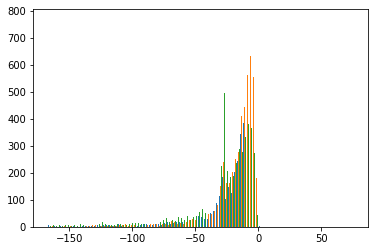

Natural drift:  -43.15279859148215 -51.63644685058283
cutoff percentile:  65
cutoff:  -6.552998679432699
acc:  0.5403
acc in: 0.3278
acc out 0.7528
vgg11-cifar10-100
(0.5845, 0.6399588)


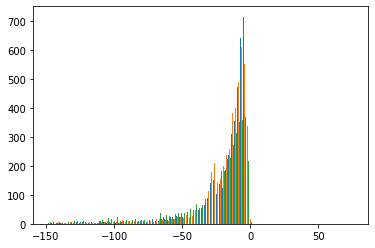

Natural drift:  -43.15279859148215 -51.63644685058283
cutoff percentile:  65
cutoff:  -6.552998679432699
acc:  0.5403
acc in: 0.3278
acc out 0.7528
vgg11-cifar10-100
(0.5024, 0.49624824)


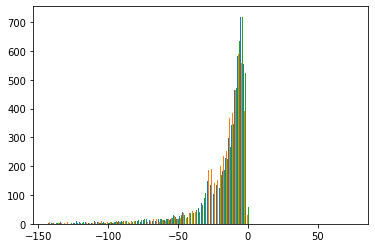

Natural drift:  -43.15279859148215 -51.63644685058283
cutoff percentile:  66
cutoff:  -6.379489872442267
acc:  0.5025
acc in: 0.3178
acc out 0.6872
vgg11-cifar10-100
(0.6003, 0.66775964)


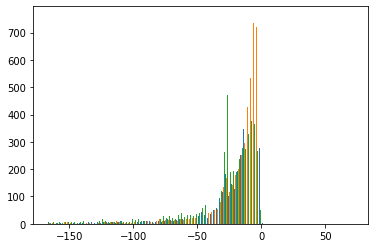

Natural drift:  -43.15279859148215 -51.63644685058283
cutoff percentile:  66
cutoff:  -6.379489872442267
acc:  0.5025
acc in: 0.3178
acc out 0.6872
vgg11-cifar10-100
(0.5827, 0.6399588)


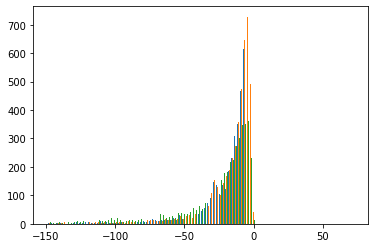

Natural drift:  -43.15279859148215 -51.63644685058283
cutoff percentile:  66
cutoff:  -6.379489872442267
acc:  0.5025
acc in: 0.3178
acc out 0.6872
vgg11-cifar10-100
(0.5382, 0.53441032)


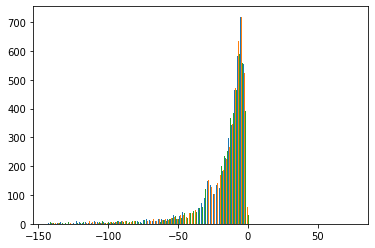

Natural drift:  -43.15279859148215 -51.63644685058283
logistic:  {}
KDE trained on cifar10. Cutoff chosen to spilt mnist and the first dataset optimally. Then evaluated on the second dataset.
test:  {'vgg11-mnist-100-fmnist-kmnist': [0.8007, 0.8232170400000001, 0.9244, 0.989], 'vgg11-mnist-100-fmnist-cifar10': [0.8418, 0.8406308, 0.9851, 0.989], 'vgg11-mnist-100-fmnist-stl10': [0.8455, 0.8437294799999999, 0.9844, 0.989], 'vgg11-mnist-100-kmnist-fmnist': [0.7844, 0.81806852, 0.9668, 0.989], 'vgg11-mnist-100-kmnist-cifar10': [0.8418, 0.8406308, 0.967, 0.989], 'vgg11-mnist-100-kmnist-stl10': [0.8455, 0.8437294799999999, 0.9675, 0.989], 'vgg11-mnist-100-cifar10-fmnist': [0.7844, 0.81806852, 0.9722, 0.989], 'vgg11-mnist-100-cifar10-kmnist': [0.8007, 0.8232170400000001, 0.9264, 0.989], 'vgg11-mnist-100-cifar10-stl10': [0.8455, 0.8437294799999999, 0.9873, 0.989], 'vgg11-mnist-100-stl10-fmnist': [0.7844, 0.81806852, 0.9691, 0.989], 'vgg11-mnist-100-stl10-kmnist': [0.8007, 0.8232170400000001, 0

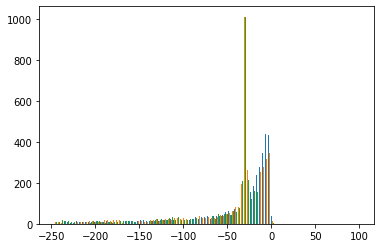

Natural drift:  -0.0034723255577987205 -83.31251098001404
cutoff percentile:  0
cutoff:  -0.04195271470710615
acc:  0.5002
acc in: 0.0006
acc out 0.9998
vgg11-stl10-100
(0.5002, 0.57007344)


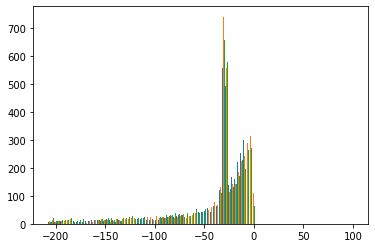

Natural drift:  -0.0034723255577987205 -83.31251098001404
cutoff percentile:  0
cutoff:  -0.04195271470710615
acc:  0.5002
acc in: 0.0006
acc out 0.9998
vgg11-stl10-100
(0.5002, 0.52944616)


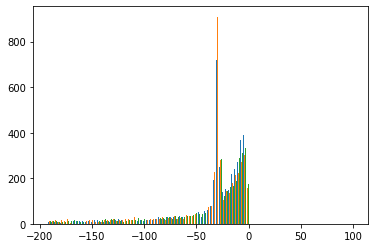

Natural drift:  -0.0034723255577987205 -83.31251098001404
cutoff percentile:  0
cutoff:  -0.04195271470710615
acc:  0.5002
acc in: 0.0006
acc out 0.9998
vgg11-stl10-100
(0.5002, 0.5414079199999999)


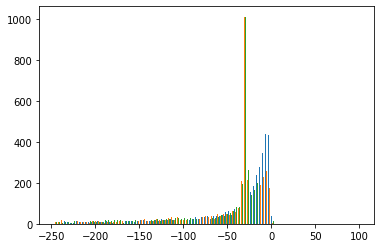

Natural drift:  -0.0034723255577987205 -83.31251098001404
cutoff percentile:  0
cutoff:  -0.04195271470710615
acc:  0.5002
acc in: 0.0006
acc out 0.9998
vgg11-stl10-100
(0.5002, 0.57007344)


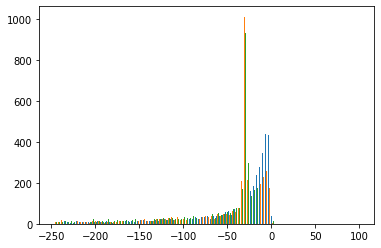

Natural drift:  -0.0034723255577987205 -83.31251098001404
cutoff percentile:  0
cutoff:  -0.04195271470710615
acc:  0.5002
acc in: 0.0006
acc out 0.9998
vgg11-stl10-100
(0.5002, 0.52944616)


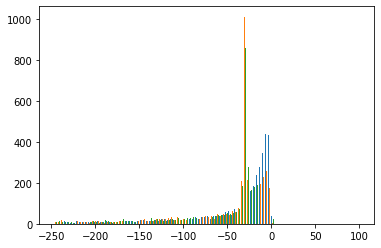

Natural drift:  -0.0034723255577987205 -83.31251098001404
cutoff percentile:  0
cutoff:  -0.04195271470710615
acc:  0.5002
acc in: 0.0006
acc out 0.9998
vgg11-stl10-100
(0.5002, 0.5414079199999999)


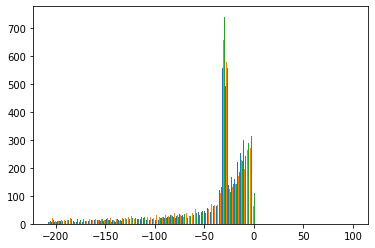

Natural drift:  -0.0034723255577987205 -83.31251098001404
cutoff percentile:  0
cutoff:  -0.04195271470710615
acc:  0.5002
acc in: 0.0006
acc out 0.9998
vgg11-stl10-100
(0.5002, 0.61470468)


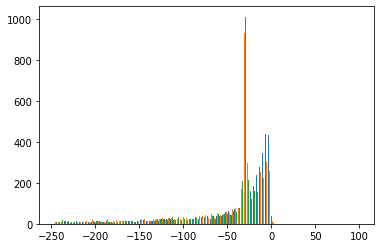

Natural drift:  -0.0034723255577987205 -83.31251098001404
cutoff percentile:  0
cutoff:  -0.04195271470710615
acc:  0.5002
acc in: 0.0006
acc out 0.9998
vgg11-stl10-100
(0.5002, 0.52944616)


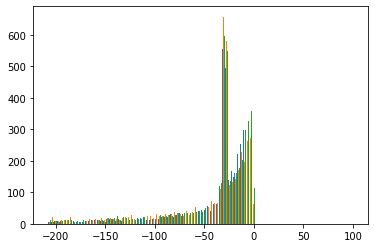

Natural drift:  -0.0034723255577987205 -83.31251098001404
cutoff percentile:  0
cutoff:  -0.04195271470710615
acc:  0.5002
acc in: 0.0006
acc out 0.9998
vgg11-stl10-100
(0.5002, 0.5414079199999999)


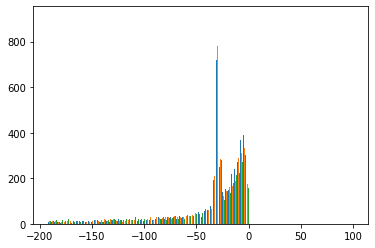

Natural drift:  -0.0034723255577987205 -83.31251098001404
cutoff percentile:  0
cutoff:  -0.04195271470710615
acc:  0.5002
acc in: 0.0006
acc out 0.9998
vgg11-stl10-100
(0.5002, 0.61470468)


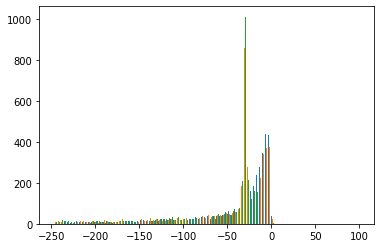

Natural drift:  -0.0034723255577987205 -83.31251098001404
cutoff percentile:  0
cutoff:  -0.04195271470710615
acc:  0.5002
acc in: 0.0006
acc out 0.9998
vgg11-stl10-100
(0.5002, 0.57007344)


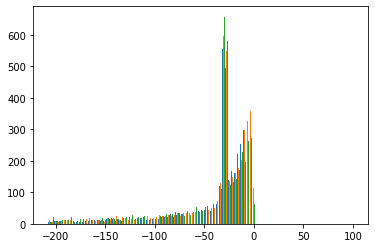

Natural drift:  -0.0034723255577987205 -83.31251098001404
logistic:  {}
KDE trained on stl10. Cutoff chosen to spilt mnist and the first dataset optimally. Then evaluated on the second dataset.
test:  {'vgg11-mnist-100-fmnist-kmnist': [0.8007, 0.8232170400000001, 0.9244, 0.989], 'vgg11-mnist-100-fmnist-cifar10': [0.8418, 0.8406308, 0.9851, 0.989], 'vgg11-mnist-100-fmnist-stl10': [0.8455, 0.8437294799999999, 0.9844, 0.989], 'vgg11-mnist-100-kmnist-fmnist': [0.7844, 0.81806852, 0.9668, 0.989], 'vgg11-mnist-100-kmnist-cifar10': [0.8418, 0.8406308, 0.967, 0.989], 'vgg11-mnist-100-kmnist-stl10': [0.8455, 0.8437294799999999, 0.9675, 0.989], 'vgg11-mnist-100-cifar10-fmnist': [0.7844, 0.81806852, 0.9722, 0.989], 'vgg11-mnist-100-cifar10-kmnist': [0.8007, 0.8232170400000001, 0.9264, 0.989], 'vgg11-mnist-100-cifar10-stl10': [0.8455, 0.8437294799999999, 0.9873, 0.989], 'vgg11-mnist-100-stl10-fmnist': [0.7844, 0.81806852, 0.9691, 0.989], 'vgg11-mnist-100-stl10-kmnist': [0.8007, 0.8232170400000001,

In [ ]:
import matplotlib.pyplot as plt


load = True
train_kde = True


def get_model(id,load,dataset,settings={},extra=False):
  model_name,dataset_name,rep_dim = id.split('-')
  rep_dim=int(rep_dim)
  if load and os.path.isfile(f'./drive/My Drive/KDE OOD/{id}.pth'):
    model = torch.load(f'./drive/My Drive/KDE OOD/{id}.pth')
    print('loaded model ' + id)
  else:
    print('training ' + id)
    model = initialize_model(model_name, rep_dim)
    if id in settings:
      model=train_model(dataset[0],model,dataset_name,model_name,num_epochs=settings[id][0],lr=settings[id][1])
    else:
      model=train_model(dataset[0],model,dataset_name,model_name) 
    torch.save(model, f'./drive/My Drive/KDE OOD/{id}.pth')

  if extra:
    model=train_model(dataset[0],model,dataset_name,model_name,num_epochs=settings[id][0],lr=settings[id][1])
    torch.save(model, f'./drive/My Drive/KDE OOD/{id}.pth')

  return model


def get_compress(id,load,dataset,rep_dim,max_len,model=None):
    split_to_ids = {'train':0,'val':1,'test':2}
    idx = split_to_ids[id.split('-')[-1]]
    if load and os.path.isfile(f'./drive/My Drive/KDE OOD/{id}.npy'):
      comp = np.load(f'./drive/My Drive/KDE OOD/{id}.npy')
      print('loaded compressed '+id)
    else:
      comp = compress(dataset[idx],model,int(rep_dim),max_len=max_len)
      np.save(f'./drive/My Drive/KDE OOD/{id}.npy',comp)
      print('compressed '+ id) 
    return comp[:max_len]

def get_score(id,kde,comp,load_scores,max_len):
    if load_scores and os.path.isfile(f'./drive/My Drive/KDE OOD/{id} scores.npy'):
      score = np.load(f'./drive/My Drive/KDE OOD/{id} scores.npy')
      print(id, ' scores loaded')
    else:
      score = kde.score_samples(comp[:max_len])
      np.save(f'./drive/My Drive/KDE OOD/{id} scores.npy',score)
      print(id, ' scores calculated')
    return score
         
def run(dataset_names,model_names,id,rep_dim,load_model=True,load_comp=True,load_scores=True,train_kde=True):

  settings = {'vgg11-stl10-20':[20,0.0001],'vgg13-stl10-20':[20,0.0001],'vgg16-stl10-20':[20,0.0001],'vgg19-stl10-20':[20,0.0001],'vgg16-cifar10-20':[10,0.0001],'vgg19-cifar10-20':[10,0.00005],
            'vgg11-stl10-50':[20,0.0001],'vgg13-stl10-50':[20,0.0001],'vgg16-stl10-50':[20,0.0001],'vgg19-stl10-50':[20,0.00005],'vgg16-cifar10-50':[10,0.0001],'vgg19-cifar10-50':[10,0.00005],
            'vgg11-stl10-100':[20,0.0001],'vgg13-stl10-100':[20,0.0001],'vgg16-stl10-100':[20,0.0001],'vgg19-stl10-100':[20,0.0001],'vgg16-cifar10-100':[10,0.0001],'vgg19-cifar10-100':[10,0.00005]}

  data_dict={}
  model_dict={}
  comp_dict_train={}
  comp_dict_val={}
  comp_dict_test={}
  final_dict={}
  Dataset_dict_score_val = {}
  Dataset_dict_score_test = {}

  for name in dataset_names:
    print('initializing '+ name)
    data_dict[name]=get_dataset(name)

  for model_name in model_names:
    for dataset_name,dataset in data_dict.items():
      id = model_name +'-'+ dataset_name + '-' + str(rep_dim)
      if id in settings.keys():
        model_dict[id] = get_model(id,load_model,dataset,settings,extra=False)
      else:
        model_dict[id] = get_model(id,load_model,dataset)

  for k,model in model_dict.items():
    model_name,train_ds,_ = k.split('-')

    #compress train
    id = model_name +'-'+ train_ds + '-' + str(rep_dim) + '-train'
    comp_dict_train[id] = get_compress(id,load_comp,data_dict[train_ds],rep_dim,10000,model=model)

    #compress val
    for ds,dataset in data_dict.items():
      id = model_name +'-'+ train_ds + '-' + str(rep_dim) +'-' + ds +'-val'
      comp_dict_val[id] = get_compress(id,load_comp,dataset,rep_dim,5000,model=model)

    #compress test
    for ds,dataset in data_dict.items():
      id = model_name +'-'+ train_ds + '-' + str(rep_dim) +'-' + ds+'-test'
      comp_dict_test[id] = get_compress(id,load_comp,dataset,rep_dim,5000,model=model)


 
  for model in model_names:
    for train_ds in dataset_names: 
      in_train = comp_dict_train[model + '-' + train_ds + '-' + str(rep_dim) + '-train'][:10000]

      if train_kde:
        kde = KDE(in_train)
        print('KDE fitted')
      else:
        kde = KernelDensity()

      for ds_name in dataset_names:
        id = f'{model}-{train_ds}-{str(rep_dim)}-{ds_name}-val' 
        Dataset_dict_score_val[id] = get_score(id,kde,comp_dict_val[id],load_scores,5000)

      id = f'{model}-{train_ds}-{str(rep_dim)}-{train_ds}-test' 
      Dataset_dict_score_test[id] = get_score(id,kde,comp_dict_test[id],load_scores,5000)      


  results={}
  results_logistic={}
  for model in model_names:
    for train_ds in dataset_names:


      id = f'{model}-{train_ds}-{str(rep_dim)}-{train_ds}-val' 
      in_val_scores = Dataset_dict_score_val[id]
      id = f'{model}-{train_ds}-{str(rep_dim)}-{train_ds}-test'  
      in_test_scores = Dataset_dict_score_test[id]


      run_results={}
      not_train = dataset_names[:]
      not_train.remove(train_ds)
      id = model + '-' + train_ds + '-' + str(rep_dim)

      model_acc = evaluate_model(data_dict[train_ds][2],model_dict[id])
      for name_v,name_t in itertools.permutations(not_train,2):

        
        Dataset_v_scores=Dataset_dict_score_val[id + '-'+ name_v+'-val']
        Dataset_t_scores=Dataset_dict_score_val[id+ '-'+ name_t+'-val']


        cutoff = tune(in_val_scores,Dataset_v_scores)

        print('cutoff: ',cutoff)
        print('acc: ', (np.sum([in_test_scores>cutoff]) + np.sum([Dataset_v_scores<cutoff]))/(len(in_test_scores)+len(Dataset_v_scores)))
        print('acc in:', np.sum([in_test_scores>cutoff])/len(in_test_scores))
        print('acc out' ,np.sum([Dataset_v_scores<cutoff])/len(Dataset_v_scores))
        result = evaluate(in_test_scores,Dataset_t_scores,cutoff)
        print(id)
        print(result)
        #diagnositics
        low = min(np.mean(in_val_scores),np.mean(Dataset_v_scores),np.mean(Dataset_t_scores))
        high = max(np.mean(in_val_scores),np.mean(Dataset_v_scores),np.mean(Dataset_t_scores))
        plt.hist([in_test_scores,Dataset_v_scores,Dataset_t_scores],range=(low-100,high+100),bins=100)
        plt.show()

        print('Natural drift: ', np.mean(in_val_scores),np.mean(in_test_scores))
        #print(result)
        run_results[id+'-'+name_v + '-' + name_t] = result
        
        clf,scaler = get_classifier(comp_dict_val[id+ '-'+train_ds +'-val'],comp_dict_val[id+'-'+name_v +'-val'])
        x_1 = comp_dict_test[id+ '-'+train_ds+ '-test']
        x_2 = comp_dict_test[id+'-'+name_t +  '-test']
        x = np.concatenate((x_1,x_2))
        y = np.concatenate((np.ones(x_1.shape[0]),np.zeros(x_2.shape[0])))
        x=scaler.transform(x)
        clas_score = clf.score(x,y)

        results[id+'-'+name_v + '-' + name_t]=[result[0],result[1],clas_score,model_acc]

      print('logistic: ',results_logistic)
      print(f'KDE trained on {train_ds}. Cutoff chosen to spilt mnist and the first dataset optimally. Then evaluated on the second dataset.') 
      print('test: ',results)

      av_acc = 0
      av_auroc = 0


      for acc,auroc in run_results.values():
        av_acc += acc
        av_auroc += auroc

      av_acc = av_acc/len(run_results)
      av_auroc = av_auroc/len(run_results)  
      print(f'Train: {train_ds}, average accuracy: {av_acc:.4f}, average auroc: {av_auroc:.4f}')
      




  return results
run_id = 'test0'
#final20 = run(['mnist','fmnist','kmnist','cifar10','stl10'],['vgg11'],run_id,20,load_comp=True,load_scores=True,train_kde=False)
#final50 = run(['mnist','fmnist','kmnist','cifar10','stl10'],['vgg11','vgg13','vgg16','vgg19'],run_id,50,load_comp=True,load_scores=True,train_kde=False)  
#test = run(['mnist','fmnist','kmnist'],['vgg11'],run_id,50,load_comp=True,load_scores=True,train_kde=False)
final100 = run(['mnist','fmnist','kmnist','cifar10','stl10'],['vgg11'],run_id,100,load_comp=True,load_scores=True,train_kde=True)

'vgg11-mnist-50-fmnist-kmnist': [0.8615, 0.9207420800000001, 0.9601, 0.9938]

In [ ]:
ds_dict = {}
ds_dict['name-name'] = 1

(array([132., 118., 112., 104., 101.,  88.,  80.,  96.,  92.,  77.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

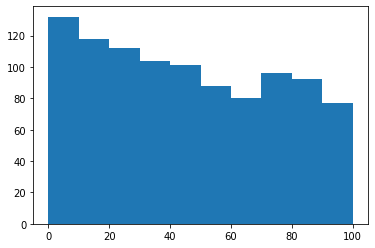

In [ ]:
id = 'vgg11' + '-' + 'cifar10' + '-' + '50' + '-val' 
in_val_scores = get_score(id,False,'',True,5000)

In [ ]:
x=np.array([1,2,3,4,5])
print(np.sum([x>2])/len(x))


# y_true = np.concatenate((np.zeros(20),np.ones(80)))
# p = np.arange(100)


# fpr, tpr, thresholds = metrics.roc_curve(y_true,p)

# print(fpr)
# print(tpr)
# print(thresholds)
# print(p[np.argmax(tpr - fpr)])
# print(Find_Optimal_Cutoff(y_true,p))

4
0.6


In [ ]:

import csv
with open('./drive/My Drive/KDE OOD/results.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',',
                            quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['model','train dataset', 'representation dimension', 'validation dataset', 'test dataset', 'accuracy', 'auroc','logistic regression','model_acc'])
    for k,v in final50.items():
        writer.writerow(k.split('-')+[v[0],v[1],v[2],v[3]])
    for k,v in final20.items():
        writer.writerow(k.split('-')+[v[0],v[1],v[2],v[3]])
    for k,v in final100.items():
        writer.writerow(k.split('-')+[v[0],v[1],v[2],v[3]])




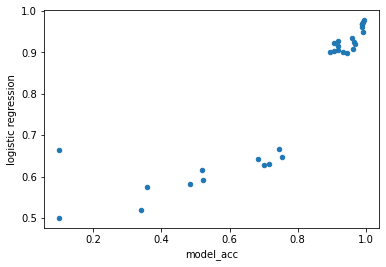

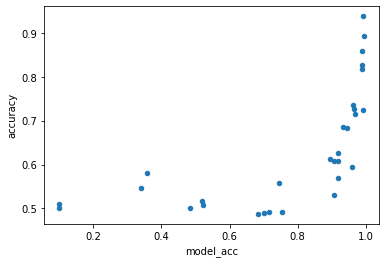

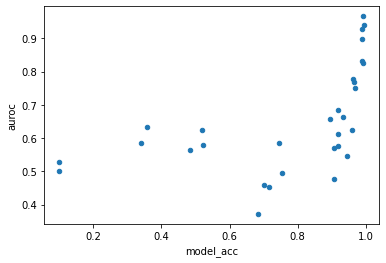

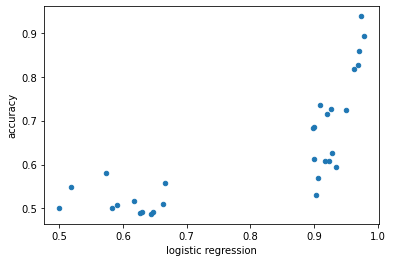

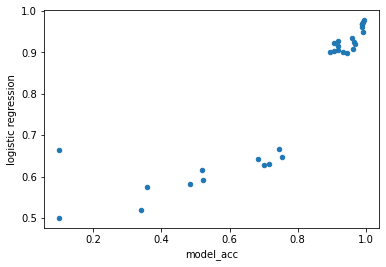

In [ ]:
import pandas as pd


df = pd.read_csv('./drive/My Drive/KDE OOD/results.csv')
df.groupby(['representation dimension','model','train dataset']).mean().plot.scatter('model_acc','logistic regression')
df.groupby(['representation dimension','model','train dataset']).mean().plot.scatter('model_acc','accuracy')
df.groupby(['representation dimension','model','train dataset']).mean().plot.scatter('model_acc','auroc')
df.groupby(['representation dimension','model','train dataset']).mean().plot.scatter('logistic regression','accuracy')
df.groupby(['representation dimension','model','train dataset']).mean().plot.scatter('model_acc','logistic regression')



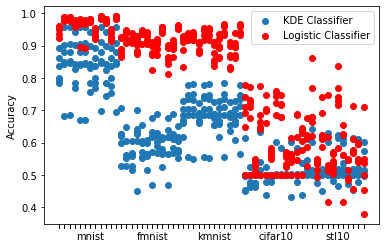

In [ ]:
import matplotlib.pyplot as plt


df = pd.read_csv('./drive/My Drive/KDE OOD/results.csv')
df['KDE Accuracy']= df['accuracy']
df['Model Accuracy']= df['model_acc']
df['id'] = df['train dataset']+'-'+df['validation dataset'] + '-' + df['test dataset']
plt.scatter('id','accuracy',data=df,label='KDE Classifier')
plt.scatter('id','logistic regression',data=df,label='Logistic Classifier',color='red')
plt.xticks(df['id'],ticks)
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [ ]:
ticks = 5*4*3*[' ']
ticks[0]=''
ticks[12]=''
ticks[6]='mnist'
ticks[18]='fmnist'
ticks[30]='kmnist'
ticks[42]='cifar10'
ticks[54]='stl10'

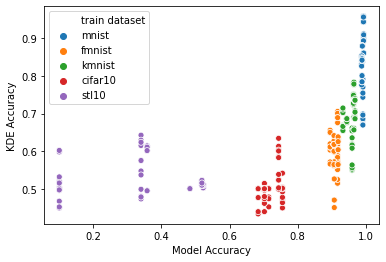

In [ ]:


import seaborn as sns
df = pd.read_csv('./drive/My Drive/KDE OOD/results.csv')
df['KDE Accuracy']= df['accuracy']
df['Model Accuracy']= df['model_acc']
axis = sns.scatterplot(data=df, x="Model Accuracy", y="KDE Accuracy", hue="train dataset",legend='brief',markers='*')

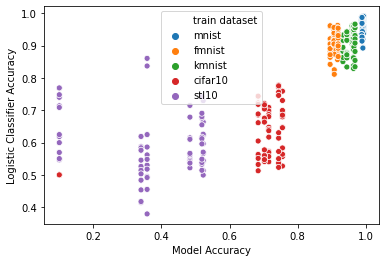

In [ ]:
import seaborn as sns
df = pd.read_csv('./drive/My Drive/KDE OOD/results.csv')
df['Logistic Classifier Accuracy']= df['logistic regression']
df['Model Accuracy']= df['model_acc']
axis = sns.scatterplot(data=df, x="Model Accuracy", y="Logistic Classifier Accuracy", hue="train dataset",legend='brief',markers='*')

In [ ]:
import seaborn as sns
df = pd.read_csv('./drive/My Drive/KDE OOD/results.csv')
_trainds= ['mnist','fmnist','kmnist','cifar10','stl10']
df['Logistic Classifier Accuracy']= df['logistic regression']
df['Model Accuracy']= df['model_acc']
axis = sns.scatterplot(data=df, x="Model Accuracy", y="KDE Accuracy", hue="train dataset",legend='brief',markers='*')

AttributeError: ignored

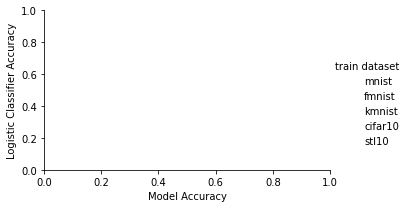

In [ ]:
import seaborn
df = pd.read_csv('./drive/My Drive/KDE OOD/results.csv')
df.to_csv('result.csv')
_trainds= ['mnist','fmnist','kmnist','cifar10','stl10']

fg = seaborn.FacetGrid(data=df, hue='train dataset', hue_order=_trainds, aspect=1.61)
fg.map(plt.scatter, 'representation dimension', 'logistic regression').add_legend()
fg.set_xlabels('Model Accuracy')
fg.set_ylabels('Logistic Classifier Accuracy')
fg.set_titles('Model accuracy vs Logistic Classifier Accuracy')


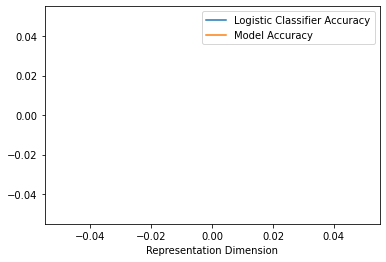

In [ ]:
plt = df[df['model']=='VGG11'].drop(columns=['auroc','accuracy']).groupby(['representation dimension']).mean().plot()
plt.legend(['Logistic Classifier Accuracy','Model Accuracy'])
plt.set_xlabel('Representation Dimension')


In [ ]:
df1 = df[df['representation dimension']==50].drop(columns=['auroc','accuracy','representation dimension'])
plt = df1.groupby(['model']).mean().plot()
plt.legend(['Logistic Classifier Accuracy', 'Model Accuracy'])

In [ ]:
plt = df.drop(columns=['auroc','accuracy']).groupby(['representation dimension']).mean().plot()


In [ ]:
print(df.columns)
df = pd.read_csv('./drive/My Drive/KDE OOD/results.csv')
df.drop(columns = 'auroc').groupby(['representation dimension','model','train dataset']).mean().to_latex()


Index(['model', 'train dataset', 'representation dimension',
       'validation dataset', 'test dataset', 'accuracy', 'auroc',
       'logistic regression', 'model_acc'],
      dtype='object')


'\\begin{tabular}{lllrrr}\n\\toprule\n    &       &       &  accuracy &  logistic regression &  model\\_acc \\\\\nrepresentation dimension & model & train dataset &           &                      &            \\\\\n\\midrule\n20  & vgg11 & cifar10 &  0.488567 &             0.627242 &   0.702300 \\\\\n    &       & fmnist &  0.608158 &             0.922875 &   0.906700 \\\\\n    &       & kmnist &  0.683792 &             0.898442 &   0.944400 \\\\\n    &       & mnist &  0.826508 &             0.968175 &   0.987900 \\\\\n    &       & stl10 &  0.580075 &             0.573892 &   0.357875 \\\\\n50  & vgg11 & cifar10 &  0.491950 &             0.629558 &   0.715200 \\\\\n    &       & fmnist &  0.626475 &             0.927700 &   0.917400 \\\\\n    &       & kmnist &  0.593825 &             0.934808 &   0.959800 \\\\\n    &       & mnist &  0.893375 &             0.977583 &   0.993800 \\\\\n    &       & stl10 &  0.508650 &             0.591233 &   0.522625 \\\\\n    & vgg13 & cifar10 & 

In [ ]:
df = pd.read_csv('./drive/My Drive/KDE OOD/results.csv')
df.columns = ['Model', 'Train Dataset', 'Representation Dimension',
       'Validation Dataset', 'Test Dataset', 'KDE Classifier Accuracy', 'AUROC',
       'Logistic Classifier Accuracy', 'Model Accuracy']
df.drop(columns = 'AUROC',).groupby(['Representation Dimension','Model']).mean().to_latex()

'\\begin{tabular}{llrrr}\n\\toprule\n    &       &  KDE Classifier Accuracy &  Logistic Classifier Accuracy &  Model Accuracy \\\\\nRepresentation Dimension & Model &                          &                               &                 \\\\\n\\midrule\n20  & vgg11 &                 0.637420 &                      0.798125 &        0.779835 \\\\\n50  & vgg11 &                 0.622855 &                      0.812177 &        0.821765 \\\\\n    & vgg13 &                 0.650672 &                      0.810620 &        0.829650 \\\\\n    & vgg16 &                 0.603520 &                      0.788227 &        0.777620 \\\\\n    & vgg19 &                 0.633558 &                      0.786620 &        0.603620 \\\\\n100 & vgg11 &                 0.640148 &                      0.809402 &        0.820785 \\\\\n\\bottomrule\n\\end{tabular}\n'

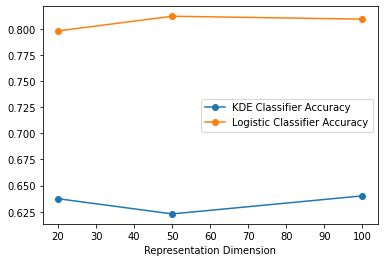

In [5]:
df = pd.read_csv('./drive/My Drive/KDE OOD/results.csv')

df.columns = ['Model', 'Train Dataset', 'Representation Dimension',
       'Validation Dataset', 'Test Dataset', 'KDE Classifier Accuracy', 'AUROC',
       'Logistic Classifier Accuracy', 'Model Accuracy']

df[df['Model']=='vgg11'].drop(columns = ['AUROC','Model Accuracy']).groupby(['Representation Dimension']).mean().plot(marker='o')


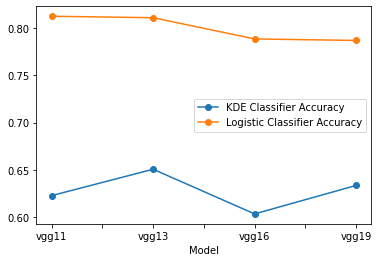

In [4]:
import pandas as pd

df = pd.read_csv('./drive/My Drive/KDE OOD/results.csv')

df.columns = ['Model', 'Train Dataset', 'Representation Dimension',
       'Validation Dataset', 'Test Dataset', 'KDE Classifier Accuracy', 'AUROC',
       'Logistic Classifier Accuracy', 'Model Accuracy']

df[df['Representation Dimension'] == 50].drop(columns = ['AUROC','Model Accuracy','Representation Dimension']).groupby(['Model']).mean().plot(marker='o')


                              Logistic Classifier Accuracy  Model Accuracy
Logistic Classifier Accuracy                       1.00000         0.39825
Model Accuracy                                     0.39825         1.00000
Correlation:  0.10042645325773163


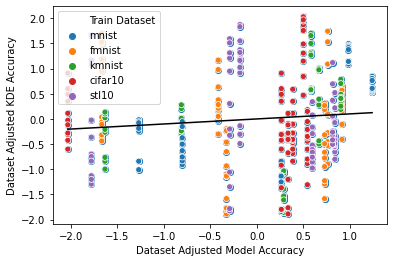

In [10]:
import matplotlib.pyplot as plt


df = pd.read_csv('./drive/My Drive/KDE OOD/results.csv')
df.columns = ['Model', 'Train Dataset', 'Representation Dimension',
       'Validation Dataset', 'Test Dataset', 'KDE Classifier Accuracy', 'AUROC',
       'Logistic Classifier Accuracy', 'Model Accuracy']

#plt.scatter(df['Model Accuracy'],df['KDE Classifier Accuracy'])
df.groupby(['Train Dataset','Validation Dataset','Test Dataset'])
df_0 = df.groupby(['Train Dataset','Validation Dataset','Test Dataset']).transform(lambda x: (x - x.mean())/x.std())
df_0['Train Dataset']=df['Train Dataset']

print(df_0[['Logistic Classifier Accuracy','Model Accuracy']].corr())



fig, ax = plt.subplots()
x = df_0['Model Accuracy']
y= df_0['KDE Classifier Accuracy']
ax.scatter(x,y)
sns.lineplot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),color = 'black')
sns.scatterplot(data=df_0, x="Model Accuracy", y="KDE Classifier Accuracy", hue="Train Dataset",legend='brief')
ax.set_xlabel('Dataset Adjusted Model Accuracy')
ax.set_ylabel('Dataset Adjusted KDE Accuracy')

print('Correlation: ',np.poly1d(np.polyfit(x, y, 1))[1])

                         KDE Classifier Accuracy  Model Accuracy
KDE Classifier Accuracy                 1.000000        0.100426
Model Accuracy                          0.100426        1.000000
Correlation:  0.39824957034266034


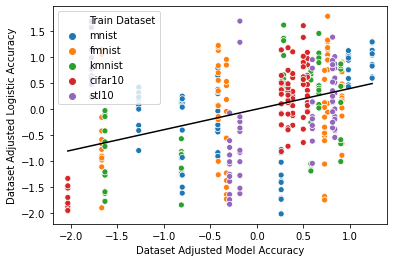

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = pd.read_csv('./drive/My Drive/KDE OOD/results.csv')
df.columns = ['Model', 'Train Dataset', 'Representation Dimension',
       'Validation Dataset', 'Test Dataset', 'KDE Classifier Accuracy', 'AUROC',
       'Logistic Classifier Accuracy', 'Model Accuracy']

#plt.scatter(df['Model Accuracy'],df['KDE Classifier Accuracy'])
df.groupby(['Train Dataset','Validation Dataset','Test Dataset'])
df_0 = df.groupby(['Train Dataset','Validation Dataset','Test Dataset']).transform(lambda x: (x - x.mean())/x.std())
df_0['Train Dataset']=df['Train Dataset']
print(df_0[['KDE Classifier Accuracy','Model Accuracy']].corr())

fig, ax = plt.subplots()
x = df_0['Model Accuracy']
y= df_0['Logistic Classifier Accuracy']
sns.lineplot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),color = 'black')
sns.scatterplot(data=df_0, x="Model Accuracy", y="Logistic Classifier Accuracy", hue="Train Dataset",legend='brief',markers='*')
ax.set_xlabel('Dataset Adjusted Model Accuracy')
ax.set_ylabel('Dataset Adjusted Logistic Accuracy')
print('Correlation: ',np.poly1d(np.polyfit(x, y, 1))[1])

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

# Get datasets
data_dict_train = {}
data_dict_test = {}
results = {}

dataset_names = ['mnist','kmnist','fmnist','cifar10','stl10']
for name in dataset_names:
  print('initializing '+ name)
  ds_train=get_dataset(name)[0]
  ds_test=get_dataset(name)[1]
  # convert to numpy
  loader = DataLoader(ds_train, batch_size=len(ds_train))
  data_dict_train[name] = next(iter(loader))[0].numpy()[:5000].reshape(5000,-1)
  print(data_dict_train[name].shape)

  loader = DataLoader(ds_test, batch_size=len(ds_test))
  data_dict_test[name] = next(iter(loader))[0].numpy()[:1000].reshape(1000,-1)

for name_A in dataset_names:
  not_train = dataset_names[:]
  not_train.remove(name_A)

  for name_B,name_C in itertools.permutations(not_train,2):
    in_vals = data_dict_train[name_A]
    out_vals = data_dict_train[name_B]
    x = np.concatenate((in_vals,out_vals))
    y = np.concatenate((np.ones(len(in_vals)),np.zeros(len(out_vals))))
    print(x.shape)
    scaler = preprocessing.StandardScaler().fit(x)
    x=scaler.transform(x)  
    clf = LogisticRegression(max_iter=10000).fit(x,y)


    in_vals = data_dict_test[name_A]
    out_vals = data_dict_test[name_C]    
    x = scaler.transform(np.concatenate((in_vals,out_vals)))
    y = np.concatenate((np.ones(in_vals.shape[0]),np.zeros(out_vals.shape[0])))
    clas_score = clf.score(x,y)
    id = name_A +'-' + name_B+'-'+name_C
    results[id]=clas_score

print(results)



initializing mnist
(5000, 3072)
initializing kmnist
(5000, 3072)
initializing fmnist
(5000, 3072)
initializing cifar10
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
(5000, 3072)
initializing stl10
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
(5000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)


In [ ]:
import csv

results = {'mnist-kmnist-fmnist': 0.993, 'mnist-kmnist-cifar10': 0.9995, 'mnist-kmnist-stl10': 0.9995, 'mnist-fmnist-kmnist': 0.991, 'mnist-fmnist-cifar10': 0.9995, 'mnist-fmnist-stl10': 0.9995, 'mnist-cifar10-kmnist': 0.869, 'mnist-cifar10-fmnist': 0.9185, 'mnist-cifar10-stl10': 0.9995, 'mnist-stl10-kmnist': 0.8585, 'mnist-stl10-fmnist': 0.861, 'mnist-stl10-cifar10': 1.0, 'kmnist-mnist-fmnist': 0.5055, 'kmnist-mnist-cifar10': 0.499, 'kmnist-mnist-stl10': 0.499, 'kmnist-fmnist-mnist': 0.618, 'kmnist-fmnist-cifar10': 0.443, 'kmnist-fmnist-stl10': 0.443, 'kmnist-cifar10-mnist': 0.513, 'kmnist-cifar10-fmnist': 0.5295, 'kmnist-cifar10-stl10': 0.9865, 'kmnist-stl10-mnist': 0.499, 'kmnist-stl10-fmnist': 0.499, 'kmnist-stl10-cifar10': 0.9945, 'fmnist-mnist-kmnist': 0.5075, 'fmnist-mnist-cifar10': 0.499, 'fmnist-mnist-stl10': 0.499, 'fmnist-kmnist-mnist': 0.7815, 'fmnist-kmnist-cifar10': 0.9565, 'fmnist-kmnist-stl10': 0.9565, 'fmnist-cifar10-mnist': 0.604, 'fmnist-cifar10-kmnist': 0.596, 'fmnist-cifar10-stl10': 0.9935, 'fmnist-stl10-mnist': 0.5355, 'fmnist-stl10-kmnist': 0.571, 'fmnist-stl10-cifar10': 0.997, 'cifar10-mnist-kmnist': 0.631, 'cifar10-mnist-fmnist': 0.5815, 'cifar10-mnist-stl10': 0.5005, 'cifar10-kmnist-mnist': 0.981, 'cifar10-kmnist-fmnist': 0.9645, 'cifar10-kmnist-stl10': 0.5075, 'cifar10-fmnist-mnist': 0.892, 'cifar10-fmnist-kmnist': 0.9, 'cifar10-fmnist-stl10': 0.5025, 'cifar10-stl10-mnist': 0.684, 'cifar10-stl10-kmnist': 0.684, 'cifar10-stl10-fmnist': 0.6095, 'stl10-mnist-kmnist': 0.6415, 'stl10-mnist-fmnist': 0.639, 'stl10-mnist-cifar10': 0.5, 'stl10-kmnist-mnist': 0.998, 'stl10-kmnist-fmnist': 0.998, 'stl10-kmnist-cifar10': 0.5025, 'stl10-fmnist-mnist': 0.964, 'stl10-fmnist-kmnist': 0.9285, 'stl10-fmnist-cifar10': 0.5025, 'stl10-cifar10-mnist': 0.4675, 'stl10-cifar10-kmnist': 0.4675, 'stl10-cifar10-fmnist': 0.542}
with open('./drive/My Drive/KDE OOD/results_base.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',',
                            quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['Dataset A','Dataset B', 'Dataset C', 'Accuracy'])
    for k,v in results.items():
        writer.writerow(k.split('-')+[v])


,Accuracy
Dataset A,
cifar10,0.703167
fmnist,0.708083
kmnist,0.585750
mnist,0.957375
stl10,0.679250


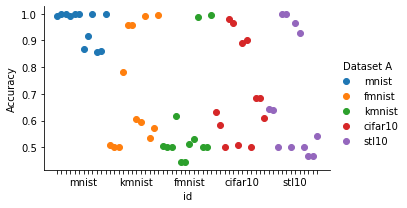

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn

ticks = 5*4*3*[' ']
ticks[0]=''
ticks[12]=''
ticks[6]='mnist'
ticks[18]='fmnist'
ticks[30]='kmnist'
ticks[42]='cifar10'
ticks[54]='stl10'

df = pd.read_csv('./drive/My Drive/KDE OOD/results_base.csv')
_trainds= ['mnist','fmnist','kmnist','cifar10','stl10']
df['id']= df['Dataset A']+'-'+df['Dataset B']+'-'+df['Dataset C']

fg = seaborn.FacetGrid(data=df, hue='Dataset A', hue_order=_trainds, aspect=1.61)
fg.map(plt.scatter, 'id', 'Accuracy').add_legend()
plt.xticks(df['id'],ticks)

df.groupby('Dataset A').mean()

In [ ]:
df = pd.read_csv('./drive/My Drive/KDE OOD/results.csv')
df[['train dataset','accuracy','logistic regression']].groupby('train dataset').mean().to_latex()

,accuracy,logistic regression
train dataset,,
cifar10,0.503081,0.619076
fmnist,0.592786,0.912531
kmnist,0.690314,0.914658
mnist,0.843306,0.967089
stl10,0.527325,0.590954


## Sanity Test

In [ ]:
ds1 = get_dataset('mnist')[2]
ds2 = get_dataset('mnist')[2]

idx1 = ds1.targets!=7
idx2 = ds2.targets==7

ds1.targets = ds1.targets[idx1]
ds1.data = ds1.data[idx1]
ds2.targets = ds2.targets[idx2]
ds2.data = ds2.data[idx2]

model = get_model('vgg11-mnist-50',True)


ds1 = compress(ds1,model,50)
ds2 = compress(ds2,model,50)

print(len(ds1),len(ds2))
kde = KDE(ds1[:1000])
scores_0 = kde.score_samples(ds1[:1000])
scores_1 =  kde.score_samples(ds1[1000:2000])
scores_2 =  kde.score_samples(ds1[5000:6000])
scores_3 = kde.score_samples(ds2)


TypeError: ignored

-82.47931292283586 -88.23187000169649 -88.0513569919106 0.24920911497035134


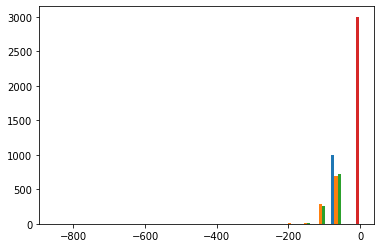

In [ ]:
scores = np.concatenate((scores_1,scores_2))
lables = np.concatenate( (np.ones(scores_1.shape[0]),np.zeros(scores_2.shape[0])))
auroc= roc_auc_score(lables,scores)
plt.hist([scores_0,scores_1,scores_2,scores_3],bins=20)
print(np.mean(scores_0),np.mean(scores_1),np.mean(scores_2),np.mean(scores_3))

In [ ]:
in_ds_train = get_dataset('cifar10')[2]
in_ds_val = get_dataset('cifar10')[2]
in_ds_test = get_dataset('cifar10')[2]


out_ds_test = get_dataset('cifar10')[2]
out_ds_val = get_dataset('cifar10')[2]


in_ds_train.targets = in_ds_train.targets[:1000]
in_ds_train.data = in_ds_train.data[:1000]
in_ds_val.targets = in_ds_val.targets[1000:2000]
in_ds_val.data = in_ds_val.data[1000:2000]
in_ds_test.targets = in_ds_test.targets[2000:3000]
in_ds_test.data = in_ds_test.data[2000:3000]

out_ds_test.targets = out_ds_test.targets[3000:4000]
out_ds_test.data = out_ds_test.data[3000:4000]
out_ds_val.targets = out_ds_val.targets[4000:5000]
out_ds_val.data = out_ds_val.data[4000:5000]

model = get_model('vgg11-cifar10-50',True,False)


in_ds_train = compress(in_ds_train,model,50)
in_ds_val = compress(in_ds_val,model,50)
in_ds_test = compress(in_ds_test,model,50)

out_ds_test = compress(out_ds_test,model,50)
out_ds_val = compress(out_ds_val,model,50)

kde = KDE(in_ds_train)
scores_in_test = kde.score_samples(in_ds_test)
scores_in_val =  kde.score_samples(in_ds_val)

scores_out_test = kde.score_samples(out_ds_test)
scores_out_val =  kde.score_samples(out_ds_val)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
loaded model vgg11-cifar10-50
best bandwidth: 4.281332398719387


-128.3818750464304 -132.09292356761964 0.528125
cutoff percentile:  28
(0.513, 0.528125)


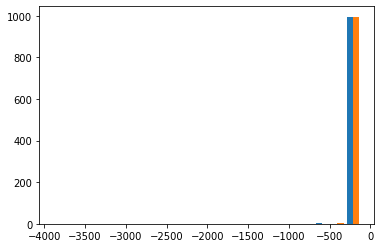

In [ ]:
scores = np.concatenate((scores_in_val,scores_out_val))
lables = np.concatenate( (np.ones(scores_in_val.shape[0]),np.zeros(scores_out_val.shape[0])))
auroc= roc_auc_score(lables,scores)
plt.hist([scores_in_test,scores_out_test],bins=20)
print(np.mean(scores_in_test),np.mean(scores_out_test),auroc)

cutoff = tune(scores_in_test,scores_out_test)
result = evaluate(scores_in_val,scores_out_val,cutoff)

print(result)



In [ ]:
import sklearn
for dataset in ['mnist','kmnist','fmnist','cifar10','stl10']:
  ds = get_dataset(dataset)[2]

  idx=[ds.targets == i for i in range(10)]

  ds_arr=10*[0]
  for i in range(10):
    ds_0 =  get_dataset(dataset)[2]
    ds_arr[i] = ds_0

  for i in range(10):
    ds_arr[i].targets = ds_arr[i].targets[idx[i]]
    ds_arr[i].data = ds_arr[i].data[idx[i]]


  model = get_model('vgg11-'+dataset+'-50',True,False)

  ds_arr = [compress(ds_arr[i],model,50) for i in range(10)]
  print('compressed')
  ds_train = [ds_arr[i][:500] for i in range(10)]
  ds_test = np.array([ds_arr[i][500:800] for i in range(10)]).reshape(3000,50)
  labels = np.floor(np.arange(len(ds_test))/300)

  kde = [KDE(ds_train[i]) for i in range(10)]

  scores_train = np.array([kde[i].score_samples(ds_test) for i in range(10)]) # score[i][j] = kde trained on i, evaluated on j
  print(scores_train.shape)
  pred = np.argmax(scores_train,axis=0)
  print(pred,labels)
  sklearn.metrics.accuracy_score(labels, pred)

loaded model vgg11-mnist-50
compressed
best bandwidth: 0.3359818286283781
best bandwidth: 0.3359818286283781
best bandwidth: 0.3359818286283781
best bandwidth: 0.3359818286283781
best bandwidth: 0.7847599703514607
best bandwidth: 0.7847599703514607
best bandwidth: 1.8329807108324339
best bandwidth: 0.7847599703514607
best bandwidth: 0.3359818286283781
best bandwidth: 0.3359818286283781
(10, 3000)
[0 0 0 ... 9 9 9] [0. 0. 0. ... 9. 9. 9.]
loaded model vgg11-kmnist-50
compressed
best bandwidth: 0.7847599703514607
best bandwidth: 0.7847599703514607
best bandwidth: 1.8329807108324339
best bandwidth: 1.8329807108324339
best bandwidth: 0.7847599703514607
best bandwidth: 0.7847599703514607
best bandwidth: 1.8329807108324339
best bandwidth: 1.8329807108324339
best bandwidth: 0.7847599703514607
best bandwidth: 0.7847599703514607
(10, 3000)
[0 0 0 ... 1 9 9] [0. 0. 0. ... 9. 9. 9.]
loaded model vgg11-fmnist-50
compressed
best bandwidth: 1.8329807108324339
best bandwidth: 1.8329807108324339
best 

ValueError: ignored

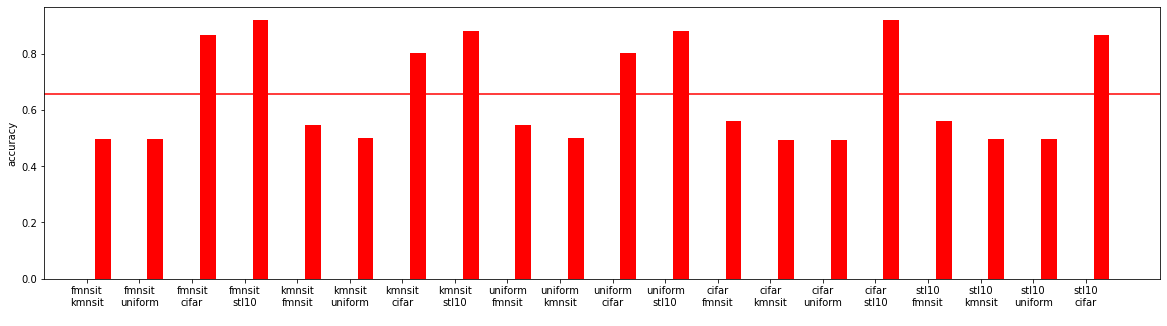

In [ ]:
labels = results_rep.keys()
accuracy_rep = [x[0] for x in results_rep.values()]
auroc_rep = [x[1] for x in results_rep.values()]
labels = [''.join([i+'\n' for i in str(j).split()]) for j in labels]
x_pos = np.arange(len(labels))

fig,ax = plt.subplots()
#kde_plt=ax.bar(x_pos,accuracy,color='b',width=0.3)
rep_plt = ax.bar(x_pos+0.3,accuracy_rep,color='r',width=0.3)

#ax.axhline(np.mean(accuracy),color='b')
ax.axhline(np.mean(accuracy_rep),color='r')


#ax.legend((kde_plt,rep_plt),('KDE','KDE in final layer'))
ax.set_ylabel('accuracy')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
fig.set_size_inches(20,5)
fig.show()



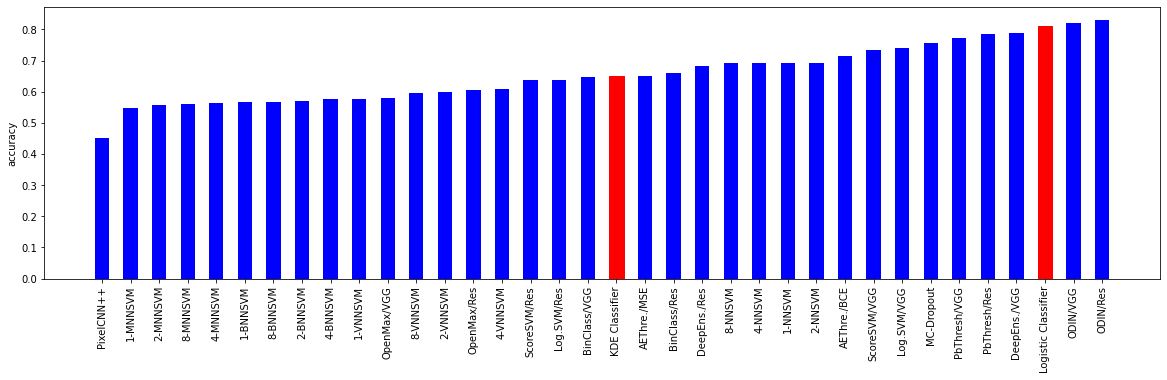

In [10]:
 methods = """ODIN/VGG
ScoreSVM/VGG
ODIN/Res
Log.SVM/VGG
AEThre./BCE
MC-Dropout
1-NNSVM
2-NNSVM
DeepEns./VGG
4-NNSVM
PbThresh/VGG
8-NNSVM
4-BNNSVM
8-BNNSVM
2-BNNSVM
1-BNNSVM
1-MNNSVM
8-MNNSVM
4-MNNSVM
2-MNNSVM
AEThre./MSE
PbThresh/Res
ScoreSVM/Res
BinClass/Res
Log.SVM/Res
BinClass/VGG
4-VNNSVM
2-VNNSVM
8-VNNSVM
DeepEns./Res
1-VNNSVM
OpenMax/VGG
PixelCNN++
OpenMax/Res""".split("\n")

values = [0.8216190476,
0.7346904762,
0.8314285714,
0.7394285714,
0.7149761905,
0.7578095238,
0.692547619,
0.6930714286,
0.7879047619,
0.691452381,
0.7724047619,
0.6911904762,
0.5762142857,
0.5680238095,
0.5708809524,
0.5673095238,
0.5479761905,
0.5601428571,
0.5638809524,
0.5573809524,
0.6516428571,
0.786,
0.6361428571,
0.6617142857,
0.6367380952,
0.6488571429,
0.6077619048,
0.5987380952,
0.5950952381,
0.6826666667,
0.5766428571,
0.5784047619,
0.4524047619,
0.6069285714]

ood_results = dict(zip(methods,values))
ood_results['KDE Classifier']=0.650672
ood_results['Logistic Classifier'] = 0.812177
ood_results = {k:v for k,v in sorted(ood_results.items(),key=lambda item: ood_results[item[0]])}

labels = list(ood_results.keys())
accuracies = ood_results.values()

x_pos = np.arange(len(labels))

fig,ax = plt.subplots()
bars=ax.bar(x_pos,accuracies,color='b',width=0.5)
bars[-18].set_color('r')
bars[-3].set_color('r')

ax.set_ylabel('accuracy')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels,rotation='vertical')
fig.set_size_inches(20,5)
fig.show()


Other

In [ ]:
import time

leaf_size = 100
for bandwidth in [2]:
  kde = KernelDensity(leaf_size=leaf_size,bandwidth=bandwidth)
  t_0 = time.time()
  kde.fit(mnist[0])
  t_1 = time.time()
  print(kde.score(mnist[1][:1000]))
  t_2 = time.time()
  print('bandwidth: ',bandwidth, ' time fit: ', t_1-t_0, ' time eval: ', t_2-t_1)

-210122.68518289574
bandwidth:  2  time fit:  1.1812660694122314  time eval:  9.638940572738647


MNIST

 Optimum leaf size = 800

rtol does nothing

alg = 'ball_tree' barely

kenrel = gaussian

bandwidth = 0.05

In [ ]:
labels = results_rep.keys()
accuracy_rep = [x[0] for x in results_rep.values()]
auroc_rep = [x[1] for x in results_rep.values()]
labels = [''.join([i+'\n' for i in str(j).split()]) for j in labels]
x_pos = np.arange(len(labels))

fig,ax = plt.subplots()
kde_plt=ax.bar(x_pos,accuracy,color='b',width=0.3)
rep_plt = ax.bar(x_pos+0.3,accuracy_rep,color='r',width=0.3)

ax.axhline(np.mean(accuracy),color='b')
ax.axhline(np.mean(accuracy_rep),color='r')


ax.legend((kde_plt,rep_plt),('KDE','KDE in final layer'))
ax.set_ylabel('accuracy')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
fig.set_size_inches(20,5)
fig.show()